# 1. Lectura de Dades

In [426]:

import pandas as pd


df_train = pd.read_csv('diamonds-train.csv')
df_test = pd.read_csv('diamonds-test.csv')


print(f"Nombre de mostres d'entrenament: {df_train.shape[0]}")
print(f"Nombre de mostres de test: {df_test.shape[0]}")


df_train.head()


Nombre de mostres d'entrenament: 44000
Nombre de mostres de test: 9940


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.53,Very Good,D,VS2,63.2,56.0,5.10,5.15,3.24,1601
1,2,0.32,Premium,H,VS2,62.4,58.0,4.36,4.33,2.71,648
2,3,0.76,Ideal,I,SI1,61.8,57.0,5.89,5.83,3.62,2399
3,4,1.01,Good,H,VS2,60.8,61.0,6.43,6.50,3.93,5229
4,5,0.73,Ideal,I,VS1,62.1,54.0,5.77,5.80,3.59,2167


# 2. Preprocessament de dades


### a.Identificar patrons amb dades "no físiques"

Els valors **"no físics"** son aquells que no tenen sentit segons el significat de la variable.

Per les característiques del diamant tenim diferents valors que consiferem erronis i en aquest cas son:
**Dimensions x, y, z <= 0** / **Valors de profunditat <= 0** / **Amplada del diamant <= 0** / **Preu < 0**

Primer haurem de detectar aquestos valors incoherents i mes endavant decidir que fer amb ells.

In [427]:

invalid_dimensions = df_train[(df_train['x'] <= 0) | (df_train['y'] <= 0) | (df_train['z'] <= 0)]
print(f"Dimensions no físiques (x, y, z <= 0): {invalid_dimensions.shape[0]} files")

invalid_depth = df_train[(df_train['depth'] <= 0)]
print(f"Valors de depth <= 0: {invalid_depth.shape[0]} files")

invalid_table = df_train[(df_train['table'] <= 0)]
print(f"Valors de table <= 0: {invalid_table.shape[0]} files")

invalid_price = df_train[(df_train['price'] < 0)]
print(f"Valors de price < 0: {invalid_price.shape[0]} files")


Dimensions no físiques (x, y, z <= 0): 16 files
Valors de depth <= 0: 0 files
Valors de table <= 0: 0 files
Valors de price < 0: 0 files


En aquest cas només tenim 16 files en els valors de x,y,z que tenen valors **"no físics"**

### b.Identificar outliers a partir de la distribució de cada atribut

**Un outlier es un valor atípic que s'allunya significativament de la resta de valors d'una variable**, per exepmle com es pot veure a la documentació si el depth dels diamants oscila entre (43 - 79) tindre un diamant amb depth = 15 es un valor molt allunyat de la mitja, que no significa que no sigui vàlid en segons quin context.

Els mètodes mes comuns son el **Z-score** i el **IQR**. El Z-score funciona noés en variables normalment distribuides en cambi l'IQR es millor quan no hi ha una simetria en les dades, per això farem servir IQR.

L'IQR és una mesura estadistica que ens diu quin és l'abast de la "zona central" de les dades. Utilitza per fer això els rangs interquartílics, si les dades estan distribuides entre el **25% - 75%** de les dades aleshores no son outliers.

           Q1       Q3      IQR  Límit inferior  Límit superior  \
carat    0.40     1.04     0.64          -0.560           2.000   
price  954.00  5315.25  4361.25       -5587.875       11857.125   
depth   61.00    62.50     1.50          58.750          64.750   
x        4.71     6.54     1.83           1.965           9.285   
y        4.72     6.53     1.81           2.005           9.245   
z        2.91     4.04     1.13           1.215           5.735   
table   56.00    59.00     3.00          51.500          63.500   

       Outliers detectats  Percentatge d'outliers  
carat              1536.0                3.490909  
price              2907.0                6.606818  
depth              2063.0                4.688636  
x                    27.0                0.061364  
y                    28.0                0.063636  
z                    41.0                0.093182  
table               490.0                1.113636  


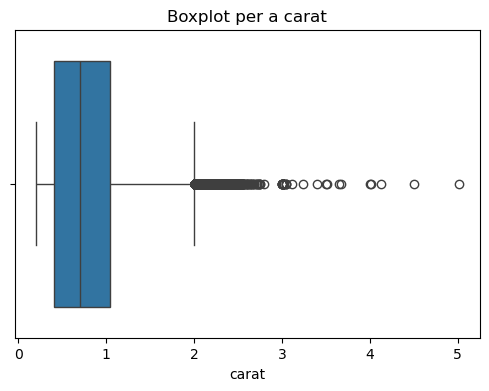

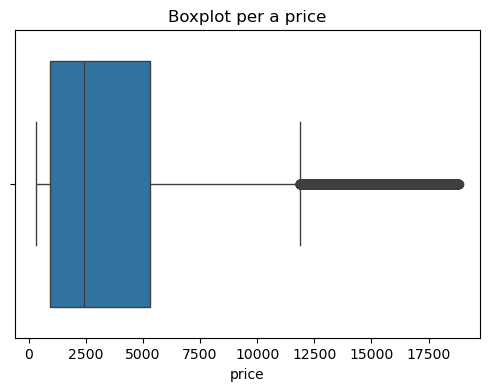

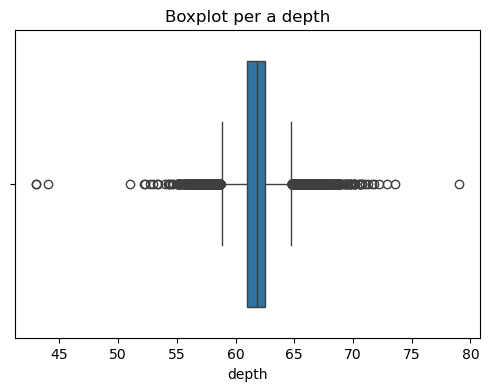

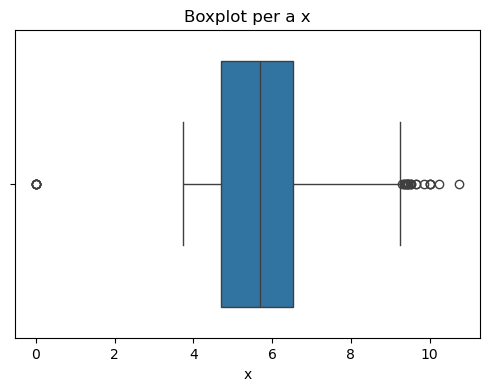

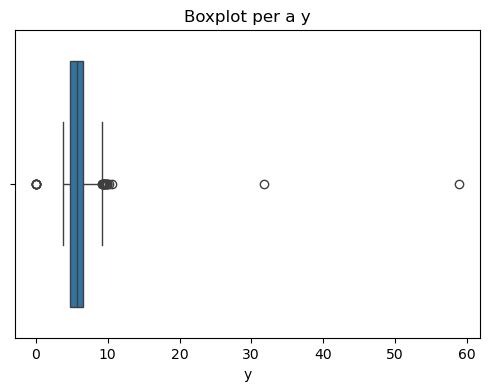

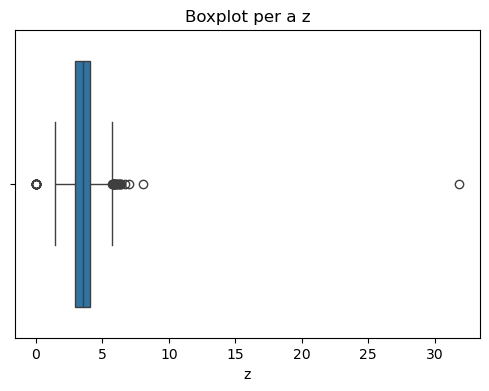

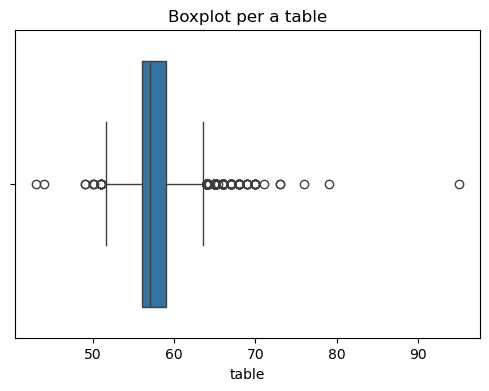

In [428]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columnes = ['carat', 'price', 'depth', 'x', 'y', 'z', 'table']

outliers_detectats = {}
estadistiques_outliers = {}

for col in columnes:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    límit_inferior = Q1 - 1.5 * IQR
    límit_superior = Q3 + 1.5 * IQR
    
    outliers = (df_train[col] < límit_inferior) | (df_train[col] > límit_superior)
    
    outliers_detectats[col] = df_train[outliers]
    
    estadistiques_outliers[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límit inferior': límit_inferior,
        'Límit superior': límit_superior,
        'Outliers detectats': outliers.sum(),
        'Percentatge d\'outliers': (outliers.sum() / len(df_train)) * 100
    }

estadistiques_df = pd.DataFrame(estadistiques_outliers).T
print(estadistiques_df)

for col in columnes:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot per a {col}')
    plt.show()


### c.Identificar outliers a partir de scatter plots atribut/preu

**Un scatter plot és un gràfic de dispersió que mostra com es distribueixen dues variables numèriques en el pla**. En aquest cas, per cada punt, l'eix x representarà un atribut i l'eix i l'eix y el preu del diamant.

Suposem que per exemple conforme el pes del diamant puja, puja el seu preu.

Els outliers de dades que **no son numeriques no els considerem** perquè no podem comparar text amb valors numerics, les gràfiques resultaríen barres per cada atribut i no hi hauría uns outliers visibles.

Compararem amb el preu els atributs numèrics, carat, x, y, z, depth i table.

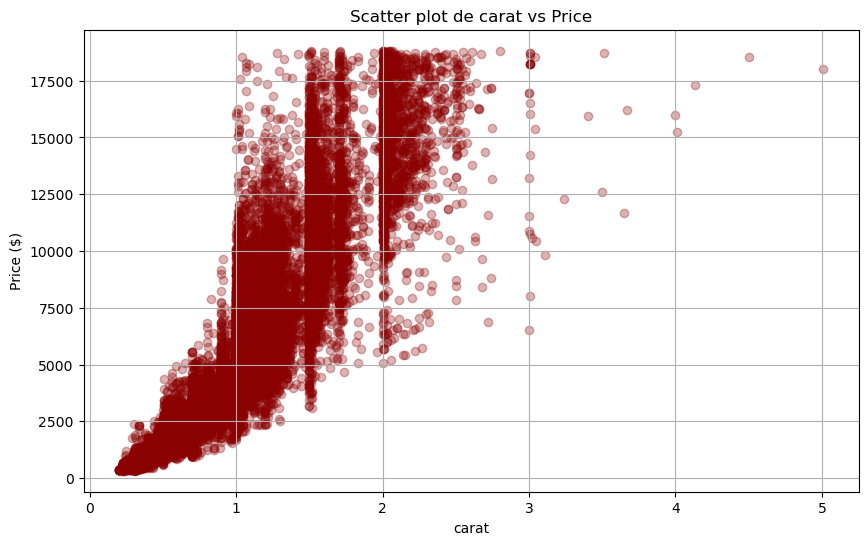

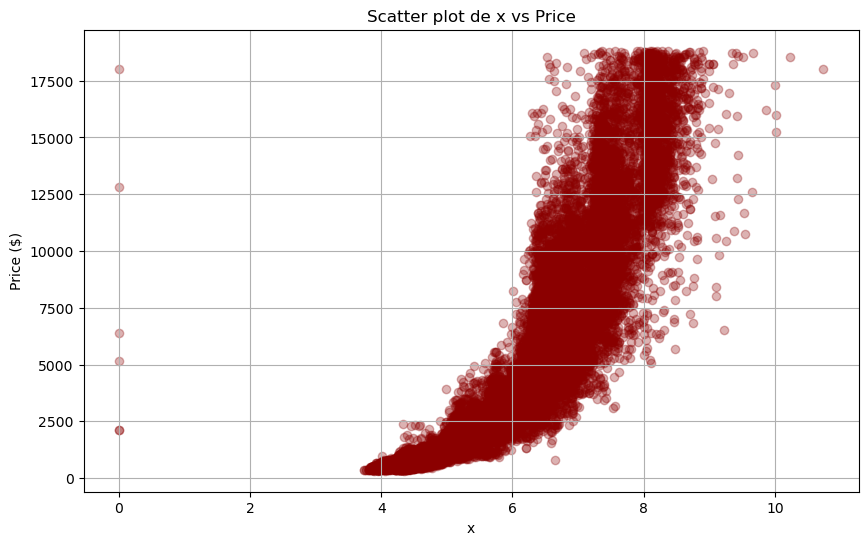

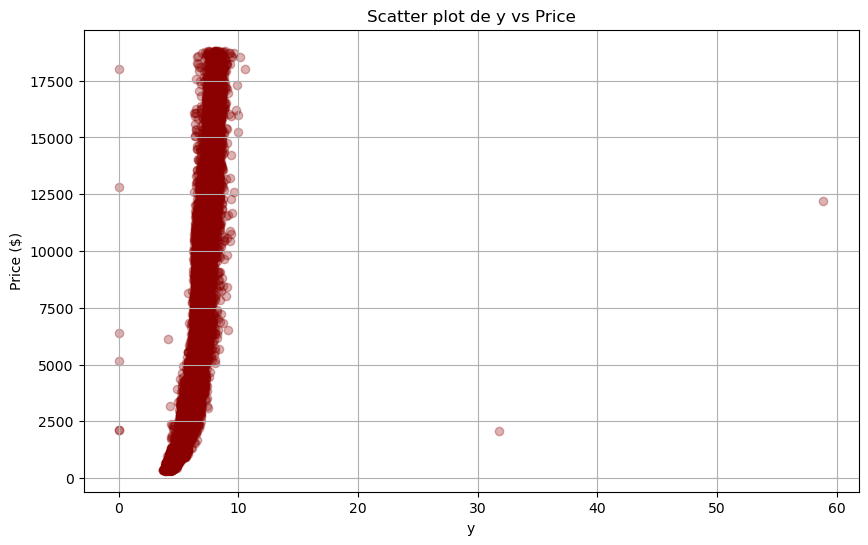

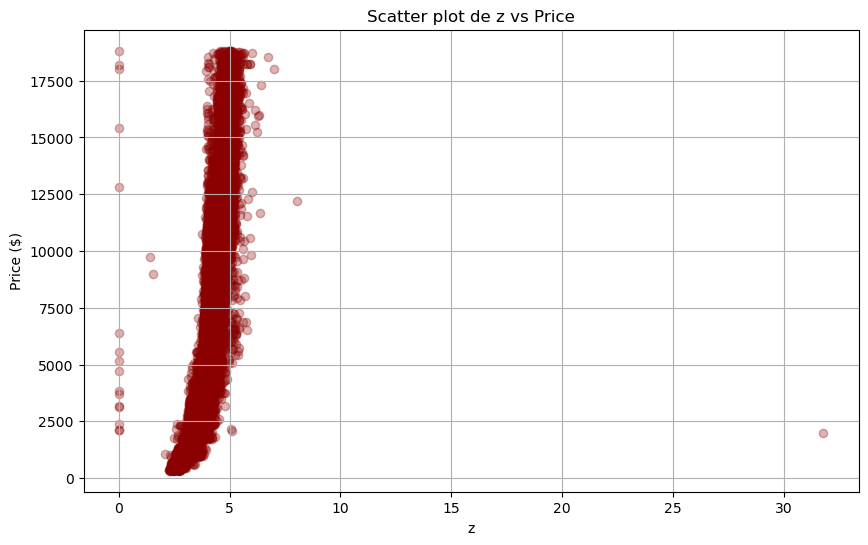

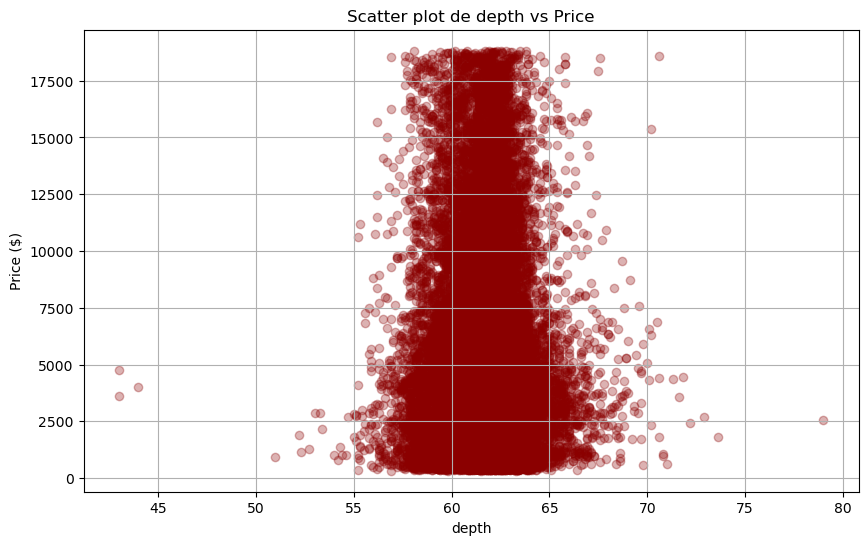

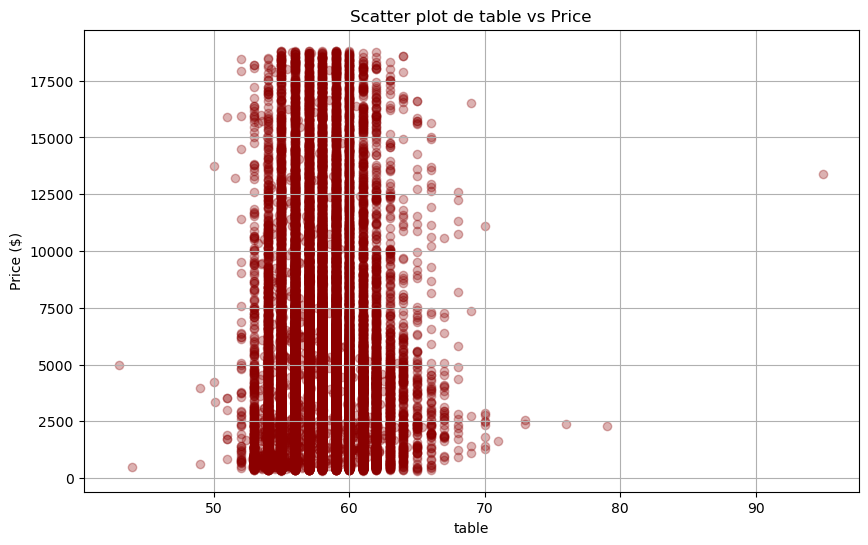

In [429]:
import matplotlib.pyplot as plt

# Atributs numèrics que volem visualitzar contra el preu
num_cols = ['carat', 'x', 'y', 'z', 'depth', 'table']

# Dibuixem el scatter plot de cada atribut vs preu
for col in num_cols:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_train[col], df_train['price'], color='darkred', alpha=0.3)
    plt.title(f"Scatter plot de {col} vs Price")
    plt.xlabel(col)
    plt.ylabel('Price ($)')
    plt.grid(True)
    plt.show()


### d.Fer una taula amb els identificadors dels outliers, els seus atributs, i les raons per la qual cadascú es considera outlier

Per realitzar la taula només hem de repetir el procès anterior de detecció d'outliers en funció del preu que es el que volem trobar aleshores eliminar els que estiguin fora del rang IQR (aquest és el motiu)


In [430]:
import pandas as pd

outliers_info = []

columnes = ['carat', 'price', 'depth', 'x', 'y', 'z', 'table']

# Iterar per cada columna i detectar outliers
for col in columnes:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    límit_inferior = Q1 - 1.5 * IQR
    límit_superior = Q3 + 1.5 * IQR
    
    # Identificar els outliers
    outliers = (df_train[col] < límit_inferior) | (df_train[col] > límit_superior)
    outliers_detectats = df_train[outliers]
    
    # Afegir la informació dels outliers a la llista
    for index, row in outliers_detectats.iterrows():
        raó = f"Valor de {col} fora del límit [ {límit_inferior}, {límit_superior} ]"
        outliers_info.append({
            "Identificador": row['id'],
            "Atribut": col,
            "Valor": row[col],
            "Raó": raó
        })

# Crear el DataFrame amb la informació dels outliers
taula_outliers = pd.DataFrame(outliers_info)
# Mostrar la taula dels outliers
print(taula_outliers)


      Identificador Atribut  Valor  \
0                79   carat   2.36   
1                84   carat   2.17   
2               158   carat   2.01   
3               181   carat   2.02   
4               205   carat   2.08   
...             ...     ...    ...   
7087          43568   table  64.00   
7088          43694   table  66.00   
7089          43751   table  64.00   
7090          43928   table  67.00   
7091          43994   table  64.00   

                                                    Raó  
0     Valor de carat fora del límit [ -0.55999999999...  
1     Valor de carat fora del límit [ -0.55999999999...  
2     Valor de carat fora del límit [ -0.55999999999...  
3     Valor de carat fora del límit [ -0.55999999999...  
4     Valor de carat fora del límit [ -0.55999999999...  
...                                                 ...  
7087       Valor de table fora del límit [ 51.5, 63.5 ]  
7088       Valor de table fora del límit [ 51.5, 63.5 ]  
7089       Valor de t

### e.Decidir què fer amb els outliers i aplicar-ho als conjunts de dades.

Decidir què fer amb els outliers depèn de diversos factors com el context del projecte, tenim diverses opcions.

**Eliminar - Substituir - Mantenir - Transformar**

En el nostre cas al tindre no moltes dades es millor eliminar, ja que al substituir per la mitjana per exemple no tenim dades suficients com per aproximar una molt correcte, mantindre el outlier no tindria sentit i transformar-ho seria massa costós.

In [431]:
columnes = ['carat', 'price', 'depth', 'x', 'y', 'z', 'table']

valors_originals = len(df_test)
eliminats_per_columna = {}

for col in columnes:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    límit_inferior = Q1 - 1.5 * IQR
    límit_superior = Q3 + 1.5 * IQR

    abans = len(df_test)
    df_test = df_test[(df_test[col] >= límit_inferior) & (df_test[col] <= límit_superior)]
    després = len(df_test)

    eliminats_per_columna[col] = abans - després

total_eliminats = valors_originals - len(df_test)

print("Nombre total de files eliminades del conjunt de test:", total_eliminats)
print("Files eliminades per columna:")
for col, n in eliminats_per_columna.items():
    print(f" - {col}: {n} files")


Nombre total de files eliminades del conjunt de test: 1190
Files eliminades per columna:
 - carat: 353 files
 - price: 337 files
 - depth: 438 files
 - x: 1 files
 - y: 0 files
 - z: 1 files
 - table: 60 files


### f. Convertir els atributs categòrics en numèrics.

Aquest pas es necesari per aplicar models a les nostres dades i tenint en compte l'ordre de millor a pitjor apliquem aquestes transformacions en atributs numèrics.

In [432]:
cut_mapping = {
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Premium': 4,
    'Ideal': 5
}
color_mapping = {
    'J': 1,
    'I': 2,
    'H': 3,
    'G': 4,
    'F': 5,
    'E': 6,
    'D': 7
}
clarity_mapping = {
    'I1': 1,
    'SI2': 2,
    'SI1': 3,
    'VS2': 4,
    'VS1': 5,
    'VVS2': 6,
    'VVS1': 7,
    'IF': 8
}

df_train['cut'] = df_train['cut'].map(cut_mapping)
df_train['color'] = df_train['color'].map(color_mapping)
df_train['clarity'] = df_train['clarity'].map(clarity_mapping)

df_test['cut'] = df_test['cut'].map(cut_mapping)
df_test['color'] = df_test['color'].map(color_mapping)
df_test['clarity'] = df_test['clarity'].map(clarity_mapping)

print(df_train.head())



   id  carat  cut  color  clarity  depth  table     x     y     z  price
0   1   0.53    3      7        4   63.2   56.0  5.10  5.15  3.24   1601
1   2   0.32    4      3        4   62.4   58.0  4.36  4.33  2.71    648
2   3   0.76    5      2        3   61.8   57.0  5.89  5.83  3.62   2399
3   4   1.01    2      3        4   60.8   61.0  6.43  6.50  3.93   5229
4   5   0.73    5      2        5   62.1   54.0  5.77  5.80  3.59   2167


### g. Estandaritzar tots els atributs per separat, excepte x, y, z i price

Estandaritzar els atributs consisteix en **transformar els valors de cada atribut per a que la seva mitjana sigui 0 i la desviació estàndard 1.** Això es fa amb aquesta formula:

**z = x (valor del atribut) - 𝜇 (mitjana del atribut) / σ (desviació estàndard)**

Això es fa perque en Machine Learning molts algorismes funcionen millor si les variables tenen escales comparables, sino podríem tindre valors grans que dominen sobre altres.

En aquest cas no s'estandaritza les mesures físiques ni el preu, el preu és el target aleshores no volem estandaritzar el que es vol predir

In [433]:
from sklearn.preprocessing import StandardScaler

atributs_a_estandaritzar = ['carat', 'depth', 'table', 'cut', 'color', 'clarity']

print("Mitjanes abans d'estandaritzar:")
print(df_train[atributs_a_estandaritzar].mean())

print("\nDesviacions abans després d'estandaritzar:")
print(df_train[atributs_a_estandaritzar].std())

scaler = StandardScaler()
df_train[atributs_a_estandaritzar] = scaler.fit_transform(df_train[atributs_a_estandaritzar])
df_test[atributs_a_estandaritzar] = scaler.transform(df_test[atributs_a_estandaritzar])

print("Mitjanes després d'estandaritzar:")
print(df_train[atributs_a_estandaritzar].mean())

print("\nDesviacions estàndard després d'estandaritzar:")
print(df_train[atributs_a_estandaritzar].std())


Mitjanes abans d'estandaritzar:
carat       0.797900
depth      61.750986
table      57.449593
cut         3.905000
color       4.408636
clarity     4.054932
dtype: float64

Desviacions abans després d'estandaritzar:
carat      0.473671
depth      1.430567
table      2.232627
cut        1.118056
color      1.701441
clarity    1.649593
dtype: float64
Mitjanes després d'estandaritzar:
carat      2.260818e-17
depth     -7.901558e-16
table     -2.452664e-15
cut        1.818343e-16
color      2.622549e-16
clarity    1.921695e-17
dtype: float64

Desviacions estàndard després d'estandaritzar:
carat      1.000011
depth      1.000011
table      1.000011
cut        1.000011
color      1.000011
clarity    1.000011
dtype: float64


### h.Escala x, y i z entre -1 i 1, però de forma conjunta, no cada atribut per separat.

Per escalar els atributs de forma cojunta entre -1 i 1 hem utilitzat una tècnica d'escalat basada en el mínim i màxim conjunt per a les tres variables

*scaled_value = (2*(value - min_value(x,y,z)) / (max_value(x,y,z) - min_value(x,y,z)))-1*

In [434]:
# Encontrar el valor mínimo y máximo global de las tres columnas
min_value = df_train[['x', 'y', 'z']].min().min()
max_value = df_train[['x', 'y', 'z']].max().max()

# Escalar las tres columnas entre -1 y 1 de forma conjunta
df_train[['x', 'y', 'z']] = 2 * ((df_train[['x', 'y', 'z']] - min_value) / (max_value - min_value)) - 1

# Ver los resultados después de la escala
print("\nDatos después de la escala:")
print(df_train[['x', 'y', 'z']].head())




Datos después de la escala:
          x         y         z
0 -0.826825 -0.825127 -0.889983
1 -0.851952 -0.852971 -0.907980
2 -0.800000 -0.802037 -0.877080
3 -0.781664 -0.779287 -0.866553
4 -0.804075 -0.803056 -0.878098


### i. Calcular el logaritme dels preus i guardar-lo en un nou atribut log_price, i aplicar un escalament lineal entre 0.1 i 0.9

In [435]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Calcular el logaritme del preu i afegir-ho com a nova columna
df_train['log_price'] = np.log(df_train['price'])

# Escalar el logaritme del preu entre 0.1 i 0.9
scaler = MinMaxScaler(feature_range=(0.1, 0.9))
df_train['log_price'] = scaler.fit_transform(df_train[['log_price']])

# Comprovar els resultats
print(df_train[['log_price', 'price']])


       log_price  price
0       0.413928   1601
1       0.235513    648
2       0.493702   2399
3       0.647397   5229
4       0.473640   2167
...          ...    ...
43995   0.621687   4590
43996   0.295205    877
43997   0.268254    765
43998   0.838407  13771
43999   0.629274   4770

[44000 rows x 2 columns]


### j.Construir un nou atribut high_price que valgui 0 si el preu està estrictament per sota dels $2,500 i 1 en cas contrari.

In [436]:
df_train['high_price'] = (df_train['price'] >= 2500).astype(int)

# Comprovar els resultats
print(df_train[['price', 'high_price']])

       price  high_price
0       1601           0
1        648           0
2       2399           0
3       5229           1
4       2167           0
...      ...         ...
43995   4590           1
43996    877           0
43997    765           0
43998  13771           1
43999   4770           1

[44000 rows x 2 columns]


# 3.Predicció del preu

# 4. Classificació del preu